In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 19.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

# Load the dataset
file_path = r"/content/training_with_glove embeddings_split.xlsx"
data = pd.read_excel(file_path, engine='openpyxl')

# Define features and target
X = data.drop(columns=['input', 'Class'])
y = data['Class']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the models and parameter grids
models = {
    'LogisticRegression': {
        'model': LogisticRegression(),
        'params': {
            'model__C': np.logspace(-4, 4, 10),
            'model__penalty': ['l1', 'l2'],
            'model__solver': ['liblinear', 'saga']
        }
    },
    'RandomForestClassifier': {
        'model': RandomForestClassifier(),
        'params': {
            'model__n_estimators': [50, 100, 200],
            'model__max_depth': [None, 10, 20, 30],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4]
        }
    },
    'SVC': {
        'model': SVC(),
        'params': {
            'model__C': np.logspace(-3, 3, 7),
            'model__gamma': ['scale', 'auto'],
            'model__kernel': ['linear', 'rbf']
        }
    },
    'KNeighborsClassifier': {
        'model': KNeighborsClassifier(),
        'params': {
            'model__n_neighbors': range(3, 15),
            'model__weights': ['uniform', 'distance'],
            'model__metric': ['euclidean', 'manhattan']
        }
    },
    'GradientBoostingClassifier': {
        'model': GradientBoostingClassifier(),
        'params': {
            'model__n_estimators': [50, 100, 200],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__max_depth': [3, 5, 7]
        }
    },
    'DecisionTreeClassifier': {
        'model': DecisionTreeClassifier(),
        'params': {
            'model__max_depth': [None, 10, 20, 30],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4]
        }
    },
    'XGBClassifier': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'params': {
            'model__n_estimators': [50, 100, 200],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__max_depth': [3, 5, 7]
        }
    },
    'CatBoostClassifier': {
        'model': CatBoostClassifier(verbose=0),
        'params': {
            'model__iterations': [100, 200, 300],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__depth': [3, 5, 7]
        }
    },
    'AdaBoostClassifier': {
        'model': AdaBoostClassifier(),
        'params': {
            'model__n_estimators': [50, 100, 200],
            'model__learning_rate': [0.01, 0.1, 0.2]
        }
    },
    'GaussianNB': {
        'model': GaussianNB(),
        'params': {}
    }
}

# Perform RandomizedSearchCV without PCA
results_no_pca = []
best_models = {}

for model_name, model_info in models.items():
    # Define the pipeline without PCA
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model_info['model'])
    ])

    # Perform hyperparameter search if params are available
    if model_info['params']:
        search = RandomizedSearchCV(pipe, model_info['params'], n_iter=10, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
        search.fit(X_train, y_train)
        best_models[model_name] = search.best_estimator_
        train_scores = cross_val_score(search.best_estimator_, X_train, y_train, cv=5, scoring='accuracy')
        train_mean = np.mean(train_scores)
        train_std = np.std(train_scores)
        results_no_pca.append({
            'Model': model_name,
            'Best Parameters': search.best_params_,
            'Best CV Score': search.best_score_,
            'Train Mean Accuracy': train_mean,
            'Train Std Dev': train_std
        })
        print(f"Best parameters for {model_name}: {search.best_params_}")
        print(f"Best CV score for {model_name}: {search.best_score_:.4f}")
    else:
        pipe.fit(X_train, y_train)
        best_models[model_name] = pipe
        train_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy')
        train_mean = np.mean(train_scores)
        train_std = np.std(train_scores)
        results_no_pca.append({
            'Model': model_name,
            'Best Parameters': "None",
            'Best CV Score': train_mean,
            'Train Mean Accuracy': train_mean,
            'Train Std Dev': train_std
        })

# Evaluate models on the test set
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    print(f"Classification report for {model_name}:\n{classification_report(y_test, y_pred)}\n")

# Perform LIME analysis
explainer = LimeTabularExplainer(X_train.values, feature_names=X_train.columns, class_names=np.unique(y_train), mode='classification')

for model_name, model in best_models.items():
    print(f"LIME Analysis for {model_name}:\n")
    sample_instance = X_test.iloc[0].values
    explanation = explainer.explain_instance(sample_instance, model.predict_proba)
    explanation.show_in_notebook()


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which 

Best parameters for LogisticRegression: {'model__solver': 'saga', 'model__penalty': 'l2', 'model__C': 0.3593813663804626}
Best CV score for LogisticRegression: 0.5052
Best parameters for RandomForestClassifier: {'model__n_estimators': 100, 'model__min_samples_split': 5, 'model__min_samples_leaf': 2, 'model__max_depth': 20}
Best CV score for RandomForestClassifier: 0.5209
Best parameters for SVC: {'model__kernel': 'rbf', 'model__gamma': 'scale', 'model__C': 1.0}
Best CV score for SVC: 0.5246
Best parameters for KNeighborsClassifier: {'model__weights': 'distance', 'model__n_neighbors': 4, 'model__metric': 'manhattan'}
Best CV score for KNeighborsClassifier: 0.4785
Best parameters for GradientBoostingClassifier: {'model__n_estimators': 100, 'model__max_depth': 5, 'model__learning_rate': 0.1}
Best CV score for GradientBoostingClassifier: 0.5194
Best parameters for DecisionTreeClassifier: {'model__min_samples_split': 10, 'model__min_samples_leaf': 4, 'model__max_depth': None}
Best CV score 

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:16:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:16:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:16:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:16:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:16:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Best parameters for XGBClassifier: {'model__n_estimators': 100, 'model__max_depth': 5, 'model__learning_rate': 0.1}
Best CV score for XGBClassifier: 0.5119
Best parameters for CatBoostClassifier: {'model__learning_rate': 0.1, 'model__iterations': 200, 'model__depth': 5}
Best CV score for CatBoostClassifier: 0.5238


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-pac

Best parameters for AdaBoostClassifier: {'model__n_estimators': 200, 'model__learning_rate': 0.2}
Best CV score for AdaBoostClassifier: 0.4881
Classification report for LogisticRegression:
              precision    recall  f1-score   support

           0       0.60      0.44      0.51       125
           1       0.45      0.65      0.53       124
           2       0.48      0.36      0.41        87

    accuracy                           0.50       336
   macro avg       0.51      0.48      0.48       336
weighted avg       0.51      0.50      0.49       336


Classification report for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.57      0.49      0.53       125
           1       0.44      0.59      0.50       124
           2       0.63      0.46      0.53        87

    accuracy                           0.52       336
   macro avg       0.55      0.51      0.52       336
weighted avg       0.54      0.52      0.52       336

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


LIME Analysis for RandomForestClassifier:



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


LIME Analysis for SVC:



AttributeError: This 'Pipeline' has no attribute 'predict_proba'

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which 

Best parameters for LogisticRegression: {'model__solver': 'saga', 'model__penalty': 'l2', 'model__C': 0.3593813663804626}
Best CV score for LogisticRegression: 0.5045
Best parameters for RandomForestClassifier: {'model__n_estimators': 200, 'model__min_samples_split': 5, 'model__min_samples_leaf': 4, 'model__max_depth': 20}
Best CV score for RandomForestClassifier: 0.5157
Best parameters for SVC: {'model__kernel': 'rbf', 'model__gamma': 'scale', 'model__C': 1.0}
Best CV score for SVC: 0.5246
Best parameters for KNeighborsClassifier: {'model__weights': 'distance', 'model__n_neighbors': 4, 'model__metric': 'manhattan'}
Best CV score for KNeighborsClassifier: 0.4785
Best parameters for GradientBoostingClassifier: {'model__n_estimators': 50, 'model__max_depth': 5, 'model__learning_rate': 0.1}
Best CV score for GradientBoostingClassifier: 0.5201
Best parameters for DecisionTreeClassifier: {'model__min_samples_split': 5, 'model__min_samples_leaf': 4, 'model__max_depth': 10}
Best CV score for 

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:54:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:54:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:54:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:54:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:54:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Best parameters for XGBClassifier: {'model__n_estimators': 100, 'model__max_depth': 5, 'model__learning_rate': 0.1}
Best CV score for XGBClassifier: 0.5119
Best parameters for CatBoostClassifier: {'model__learning_rate': 0.1, 'model__iterations': 200, 'model__depth': 5}
Best CV score for CatBoostClassifier: 0.5238


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-pac

Best parameters for AdaBoostClassifier: {'model__n_estimators': 200, 'model__learning_rate': 0.2}
Best CV score for AdaBoostClassifier: 0.4881
Classification report for LogisticRegression:
              precision    recall  f1-score   support

           0       0.60      0.44      0.51       125
           1       0.45      0.65      0.53       124
           2       0.48      0.36      0.41        87

    accuracy                           0.50       336
   macro avg       0.51      0.48      0.48       336
weighted avg       0.51      0.50      0.49       336


Classification report for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.57      0.48      0.52       125
           1       0.44      0.62      0.52       124
           2       0.68      0.44      0.53        87

    accuracy                           0.52       336
   macro avg       0.56      0.51      0.52       336
weighted avg       0.55      0.52      0.52       336

  0%|          | 0/336 [00:00<?, ?it/s]

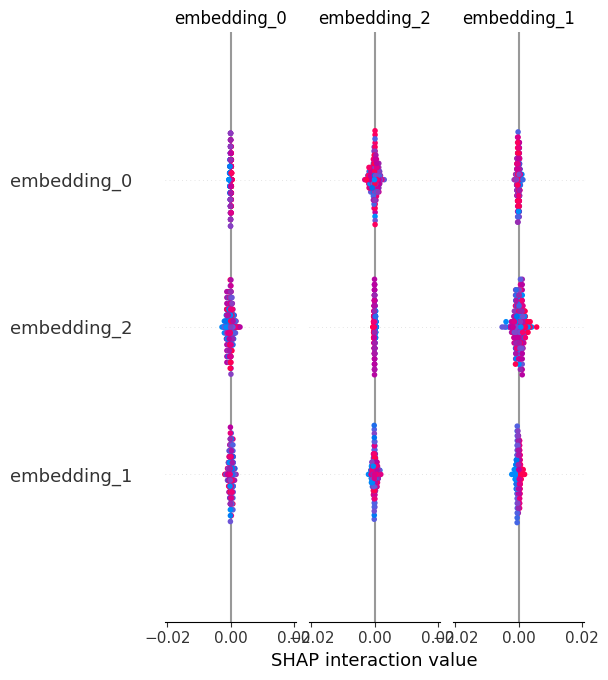

SHAP Analysis for RandomForestClassifier:



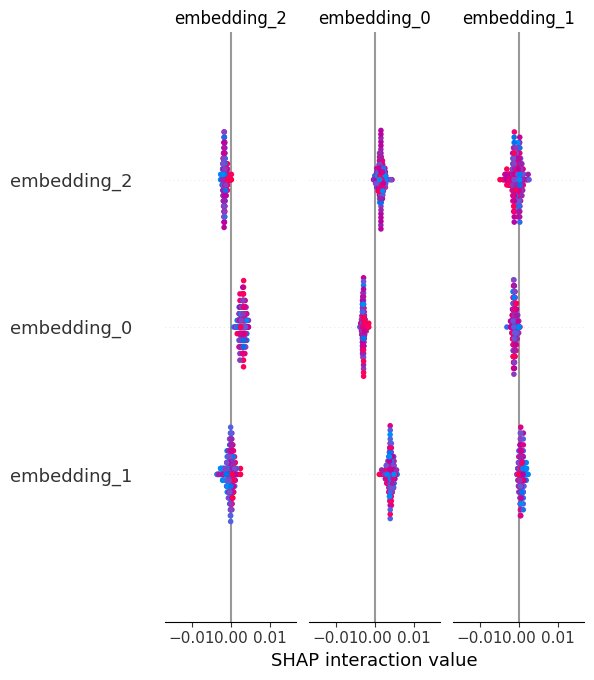

SHAP Analysis for SVC:



  0%|          | 0/336 [00:00<?, ?it/s]

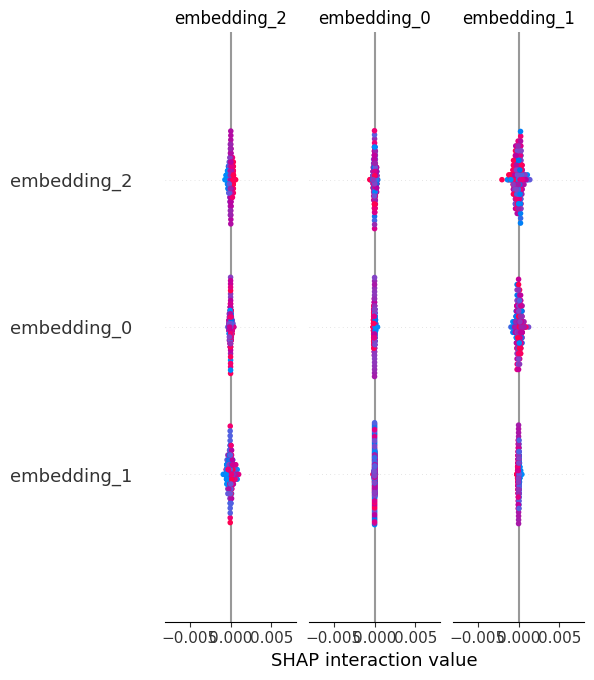

SHAP Analysis for KNeighborsClassifier:



  0%|          | 0/336 [00:00<?, ?it/s]

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
import shap
import numpy as np

# Load the dataset
file_path = r"/content/training_with_glove embeddings_split.xlsx"
data = pd.read_excel(file_path, engine='openpyxl')

# Define features and target
X = data.drop(columns=['input', 'Class'])
y = data['Class']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the models and parameter grids
models = {
    'LogisticRegression': {
        'model': LogisticRegression(),
        'params': {
            'model__C': np.logspace(-4, 4, 10),
            'model__penalty': ['l1', 'l2'],
            'model__solver': ['liblinear', 'saga']
        }
    },
    'RandomForestClassifier': {
        'model': RandomForestClassifier(),
        'params': {
            'model__n_estimators': [50, 100, 200],
            'model__max_depth': [None, 10, 20, 30],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4]
        }
    },
    'SVC': {
        'model': SVC(probability=True),
        'params': {
            'model__C': np.logspace(-3, 3, 7),
            'model__gamma': ['scale', 'auto'],
            'model__kernel': ['linear', 'rbf']
        }
    },
    'KNeighborsClassifier': {
        'model': KNeighborsClassifier(),
        'params': {
            'model__n_neighbors': range(3, 15),
            'model__weights': ['uniform', 'distance'],
            'model__metric': ['euclidean', 'manhattan']
        }
    },
    'GradientBoostingClassifier': {
        'model': GradientBoostingClassifier(),
        'params': {
            'model__n_estimators': [50, 100, 200],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__max_depth': [3, 5, 7]
        }
    },
    'DecisionTreeClassifier': {
        'model': DecisionTreeClassifier(),
        'params': {
            'model__max_depth': [None, 10, 20, 30],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4]
        }
    },
    'XGBClassifier': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'params': {
            'model__n_estimators': [50, 100, 200],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__max_depth': [3, 5, 7]
        }
    },
    'CatBoostClassifier': {
        'model': CatBoostClassifier(verbose=0),
        'params': {
            'model__iterations': [100, 200, 300],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__depth': [3, 5, 7]
        }
    },
    'AdaBoostClassifier': {
        'model': AdaBoostClassifier(),
        'params': {
            'model__n_estimators': [50, 100, 200],
            'model__learning_rate': [0.01, 0.1, 0.2]
        }
    },
    'GaussianNB': {
        'model': GaussianNB(),
        'params': {}
    }
}

# Perform RandomizedSearchCV without PCA
results_no_pca = []
best_models = {}

for model_name, model_info in models.items():
    # Define the pipeline
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model_info['model'])
    ])

    # Perform hyperparameter search if params are available
    if model_info['params']:
        search = RandomizedSearchCV(pipe, model_info['params'], n_iter=10, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
        search.fit(X_train, y_train)
        best_models[model_name] = search.best_estimator_
        train_scores = cross_val_score(search.best_estimator_, X_train, y_train, cv=5, scoring='accuracy')
        train_mean = np.mean(train_scores)
        train_std = np.std(train_scores)
        results_no_pca.append({
            'Model': model_name,
            'Best Parameters': search.best_params_,
            'Best CV Score': search.best_score_,
            'Train Mean Accuracy': train_mean,
            'Train Std Dev': train_std
        })
        print(f"Best parameters for {model_name}: {search.best_params_}")
        print(f"Best CV score for {model_name}: {search.best_score_:.4f}")
    else:
        pipe.fit(X_train, y_train)
        best_models[model_name] = pipe
        train_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy')
        train_mean = np.mean(train_scores)
        train_std = np.std(train_scores)
        results_no_pca.append({
            'Model': model_name,
            'Best Parameters': "None",
            'Best CV Score': train_mean,
            'Train Mean Accuracy': train_mean,
            'Train Std Dev': train_std
        })

# Evaluate models on the test set
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    print(f"Classification report for {model_name}:\n{classification_report(y_test, y_pred)}\n")

# Perform SHAP analysis
for model_name, model in best_models.items():
    print(f"SHAP Analysis for {model_name}:\n")
    if hasattr(model, 'named_steps') and 'model' in model.named_steps:
        model = model.named_steps['model']

    # Choose SHAP explainer based on model type
    if isinstance(model, (RandomForestClassifier, GradientBoostingClassifier, XGBClassifier)):
        explainer = shap.TreeExplainer(model)
    else:
        explainer = shap.KernelExplainer(model.predict_proba, shap.sample(X_train, 100))

    # Generate SHAP values for the test set
    shap_values = explainer.shap_values(X_test)

    # Display SHAP summary plot
    shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)


In [ ]:
!pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=16ff109036be52bac0d04760ecf3881fd3aee42e93472f811a901d8f84e05126
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


DON'T TOUCH THE COMPUTER